# Movie lens data engineering

In [170]:
MOVIE_LENS_DATA_PATH = './data/ml-25m/'
!ls $MOVIE_LENS_DATA_PATH

README.txt	   movies.csv			       ratings_imdbId.csv
genome-scores.csv  movies_preprocessed.csv	       tags.csv
genome-tags.csv    movies_preprocessed_normalized.csv  test.csv
links.csv	   ratings.csv			       train.csv


In [171]:
import pandas as pd
import numpy as np

In [4]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")
ratings.head()

In [8]:
numeric_features = []
cat_features = []

## Extract movie statistics


### Movies ave rating & numbers of ratings

In [9]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [10]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [11]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [12]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [13]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [14]:
numeric_features += ['userId_count', 'rating_mean']

## Extract movie year

In [15]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [16]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [17]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

## Movies genres

In [18]:
genres = set()

In [19]:
for g in movies['genres']:
    genres = genres.union(set(g.split('|')))

In [20]:
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [21]:
len(genres)

20

In [22]:
cat_features += ['genres']

## Tags & genres: using TF-IDF and SVD

In [23]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1361.0,Pixar,1.216146e+09


In [24]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [27]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))

In [28]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['genres', 'tag']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure Children Fantasy Robin Williams time...
2,3,Grumpier Old Men (1995),Comedy Romance funny best friend duringcredits...


### TF-IDF vectorizer

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [30]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
len(tfidf.vocabulary_)

35768

In [32]:
!mkdir ./assets

mkdir: cannot create directory ‘./assets’: File exists


In [33]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie

In [34]:
new_movie_feat = tfidf.transform(['cartoon'])

In [35]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

### SVD on content

In [36]:
NUM_LATENT_FACTOR = 10

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


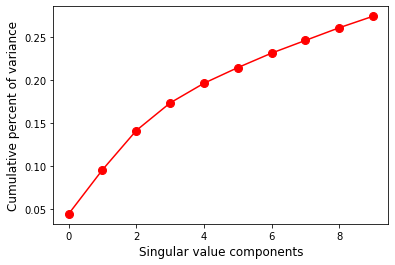

In [37]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [38]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [39]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9
1,0.040733,0.000288,0.051061,0.002787,0.028923,0.011618,-0.090201,0.293031,-0.019832,0.198527
2,0.013167,0.000391,0.005224,0.001948,0.024594,0.013564,-0.019538,0.082326,-0.009433,0.016309
3,0.025699,-0.000123,0.028008,-0.000757,0.000755,0.033774,0.006412,-0.000742,-0.004245,0.001086
4,0.099711,-0.001299,0.028952,-0.003486,-0.008666,0.069928,0.014918,-0.002358,-0.008912,0.003872
5,0.059480,-0.000102,0.083627,-0.001705,0.003634,-0.008429,-0.001650,0.017300,0.002987,0.003278


In [40]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9'],
      dtype='object')

In [41]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [42]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,movieId
1,0.040733,0.000288,0.051061,0.002787,0.028923,0.011618,-0.090201,0.293031,-0.019832,0.198527,1
2,0.013167,0.000391,0.005224,0.001948,0.024594,0.013564,-0.019538,0.082326,-0.009433,0.016309,2
3,0.025699,-0.000123,0.028008,-0.000757,0.000755,0.033774,0.006412,-0.000742,-0.004245,0.001086,3
4,0.099711,-0.001299,0.028952,-0.003486,-0.008666,0.069928,0.014918,-0.002358,-0.008912,0.003872,4
5,0.059480,-0.000102,0.083627,-0.001705,0.003634,-0.008429,-0.001650,0.017300,0.002987,0.003278,5


In [43]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [44]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000288,0.051061,0.002787,0.028923,0.011618,-0.090201,0.293031,-0.019832,0.198527
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005224,0.001948,0.024594,0.013564,-0.019538,0.082326,-0.009433,0.016309
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0.025699,-0.000123,0.028008,-0.000757,0.000755,0.033774,0.006412,-0.000742,-0.004245,0.001086
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0.099711,-0.001299,0.028952,-0.003486,-0.008666,0.069928,0.014918,-0.002358,-0.008912,0.003872
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083627,-0.001705,0.003634,-0.008429,-0.001650,0.017300,0.002987,0.003278


In [45]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

In [46]:
numeric_features

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9']

#### SVD transform new movie

In [47]:
latent_matrix = svd.transform(new_movie_feat)

In [48]:
latent_matrix.shape

(1, 10)

In [49]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

##  Popularity score

https://www.kaggle.com/rounakbanik/movie-recommender-systems?

Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole report


In [50]:
C = ratings['rating'].mean()

In [51]:
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [52]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.


In [53]:
qualified = movies[movies['userId_count'] >= m]

In [54]:
qualified.shape

(2953, 17)

In [55]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [56]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [58]:
qualified.head(100)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,wr
314,318,"Shawshank Redemption, The (1994)",Crime Drama,81482.0,4.413576,1994.0,1994.0,0.038376,0.000371,-0.019879,0.001645,0.015124,0.001077,-0.009565,0.004376,0.006091,0.001014,4.397639
840,858,"Godfather, The (1972)",Crime Drama,52498.0,4.324336,1972.0,1972.0,0.032702,0.000421,-0.011775,0.002674,0.056082,0.007953,-0.056421,-0.030045,0.015590,0.010519,4.302329
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,55366.0,4.284353,1995.0,1995.0,0.020883,0.000365,-0.005520,0.001801,0.075703,0.002278,-0.028994,-0.035695,0.018856,0.035881,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime Drama,34188.0,4.261759,1974.0,1974.0,0.020465,0.000722,-0.005198,0.003063,0.044556,0.006345,-0.043517,-0.021388,0.017745,0.006516,4.231098
522,527,Schindler's List (1993),Drama War,60411.0,4.247579,1993.0,1993.0,0.034736,0.001773,-0.017765,0.008445,0.011378,0.012030,-0.016556,0.021826,0.001056,-0.019871,4.230248
2867,2959,Fight Club (1999),Action Crime Drama Thriller,58773.0,4.228311,1999.0,1999.0,0.056161,-0.000138,0.070964,-0.000069,0.025570,-0.009277,-0.015872,-0.002923,0.002979,-0.006219,4.210990
1164,1193,One Flew Over the Cuckoo's Nest (1975),Drama,36058.0,4.218662,1975.0,1975.0,0.033359,0.000119,-0.018500,0.001295,0.002544,0.000565,0.002765,0.009025,0.004177,-0.000654,4.191252
883,904,Rear Window (1954),Mystery Thriller,20162.0,4.237948,1954.0,1954.0,0.020152,0.000388,-0.010706,0.001809,0.106421,-0.000797,0.006693,-0.041241,0.026296,0.069743,4.189089
1173,1203,12 Angry Men (1957),Drama,16569.0,4.243014,1957.0,1957.0,0.060310,-0.000790,-0.036009,0.000504,0.006381,-0.006461,-0.010101,-0.001232,0.001457,0.002046,4.184021
1930,2019,Seven Samurai (Shichinin no samurai) (1954),Action Adventure Drama,13367.0,4.254769,1954.0,1954.0,0.015977,0.000493,-0.005322,0.001409,0.025025,0.009156,-0.037102,0.010780,-0.001892,-0.035008,4.181885


## Break genres into one-hot columns

In [59]:
for g in genres:
    movies[g] = 0

In [60]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Comedy,Children,Musical,Animation,(no genres listed),Romance,Mystery,Adventure,Thriller,War
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000288,0.051061,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005224,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0.025699,-0.000123,0.028008,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0.099711,-0.001299,0.028952,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083627,...,0,0,0,0,0,0,0,0,0,0


In [61]:
from tqdm import tqdm

for i, row in tqdm(movies.iterrows(), total=len(movies)):
    try:
        row_genres = row['genres'].split('|')
        for g in row_genres:
            movies.at[i, g] = 1
    except:
        pass

100%|██████████| 62423/62423 [05:31<00:00, 188.29it/s]


In [62]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Comedy Horror Mystery Romance,Action Comedy Horror Mystery,Action Fantasy Horror War,Crime Drama Horror Mystery Sci-Fi Thriller,Animation Children Comedy Fantasy Horror,Animation Fantasy Romance,Comedy Drama Fantasy War,Children Comedy Fantasy Mystery,Children Comedy Crime Fantasy,Comedy Horror Mystery Sci-Fi Western
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,0.040733,0.000288,0.051061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,0.013167,0.000391,0.005224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0.025699,-0.000123,0.028008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0.099711,-0.001299,0.028952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0.059480,-0.000102,0.083627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
cat_features += [g for g in genres]

In [64]:
cat_features

['year_cat',
 'genres',
 'Drama',
 'Sci-Fi',
 'Documentary',
 'Crime',
 'Action',
 'Fantasy',
 'Film-Noir',
 'Western',
 'Horror',
 'IMAX',
 'Comedy',
 'Children',
 'Musical',
 'Animation',
 '(no genres listed)',
 'Romance',
 'Mystery',
 'Adventure',
 'Thriller',
 'War']

### Popularity score per genre

In [65]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [66]:
Romance_chart = build_chart('Romance')
Romance_chart.head(15)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Action Fantasy Horror War,Crime Drama Horror Mystery Sci-Fi Thriller,Animation Children Comedy Fantasy Horror,Animation Fantasy Romance,Comedy Drama Fantasy War,Children Comedy Fantasy Mystery,Children Comedy Crime Fantasy,Comedy Horror Mystery Sci-Fi Western,Romance_wr,Romance_rank
0,50912,"Paris, I Love You (Paris, je t'aime) (2006)",Romance,1385.0,3.692419,2006.0,2006.0,0.025356,0.001604,0.007081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.609887,0
1,2708,"Autumn Tale, An (Conte d'automne) (1998)",Romance,482.0,3.684647,1998.0,1998.0,0.019094,0.000142,0.005535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.570463,1
2,139747,Before We Go (2014),Romance,238.0,3.663866,2014.0,2014.0,0.024961,0.000188,0.008196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.551623,2
3,6192,Open Hearts (Elsker dig for evigt) (2002),Romance,182.0,3.670330,2002.0,2002.0,0.040729,0.002694,-0.013357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.548592,3
4,1493,Love and Other Catastrophes (1996),Romance,197.0,3.411168,1996.0,1996.0,0.135294,0.025068,0.017630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.519641,4
5,1669,"Tango Lesson, The (1997)",Romance,272.0,3.424632,1997.0,1997.0,0.022757,0.004865,0.002963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.517121,5
6,4024,"House of Mirth, The (2000)",Romance,606.0,3.419967,2000.0,2000.0,0.040443,0.000158,-0.013978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.501136,6
7,1477,Love Jones (1997),Romance,328.0,3.310976,1997.0,1997.0,0.048171,0.001220,0.011870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.493937,7
8,5664,Brown Sugar (2002),Romance,191.0,3.123037,2002.0,2002.0,0.028906,-0.000259,0.007649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.487545,8
9,8911,Raise Your Voice (2004),Romance,341.0,3.161290,2004.0,2004.0,0.017911,0.001061,0.004626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.464973,9


In [67]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')

    

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
 10%|█         | 2/20 [00:02<00:20,  1.13s/it]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
movies.fillna(0, inplace=True)

In [ ]:
movies.head()

In [ ]:
movies.shape

In [ ]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [ ]:
numeric_features

In [ ]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


# Using IMDB ID

In [173]:
links = pd.read_csv('/home/vinhngx/vinh-all-data/Recommender-movie/data/ml-25m/links.csv', dtype={'imdbId':str, 'tmdbId': str})

In [ ]:
movies = movies.merge(links, on='movieId', how='left')

In [ ]:
movies.head()

In [ ]:
movies.to_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed.csv", index=False)

# Reading back data and encoding

In [151]:
import pickle
import pandas as pd
import numpy as np

with open('./assets/features.pkl', 'rb') as f:
    feat = pickle.load(f)
    num_feats= feat['numeric_features']
    cat_feats= feat['cat_features']


In [152]:
num_feats

['userId_count',
 'rating_mean',
 'year',
 'SVD_latent_0',
 'SVD_latent_1',
 'SVD_latent_2',
 'SVD_latent_3',
 'SVD_latent_4',
 'SVD_latent_5',
 'SVD_latent_6',
 'SVD_latent_7',
 'SVD_latent_8',
 'SVD_latent_9',
 'Documentary_wr',
 'Mystery_wr',
 'Drama_wr',
 'Horror_wr',
 'Fantasy_wr',
 'Musical_wr',
 'Western_wr',
 'IMAX_wr',
 'Comedy_wr',
 'Film-Noir_wr',
 'Sci-Fi_wr',
 'Romance_wr',
 'Action_wr',
 'Adventure_wr',
 '(no genres listed)_wr',
 'Children_wr',
 'War_wr',
 'Crime_wr',
 'Thriller_wr',
 'Animation_wr',
 'Documentary_rank',
 'Mystery_rank',
 'Drama_rank',
 'Horror_rank',
 'Fantasy_rank',
 'Musical_rank',
 'Western_rank',
 'IMAX_rank',
 'Comedy_rank',
 'Film-Noir_rank',
 'Sci-Fi_rank',
 'Romance_rank',
 'Action_rank',
 'Adventure_rank',
 '(no genres listed)_rank',
 'Children_rank',
 'War_rank',
 'Crime_rank',
 'Thriller_rank',
 'Animation_rank']

In [153]:
len(num_feats)

53

In [154]:
cat_feats

['year_cat',
 'genres',
 'Documentary',
 'Mystery',
 'Drama',
 'Horror',
 'Fantasy',
 'Musical',
 'Western',
 'IMAX',
 'Comedy',
 'Film-Noir',
 'Sci-Fi',
 'Romance',
 'Action',
 'Adventure',
 '(no genres listed)',
 'Children',
 'War',
 'Crime',
 'Thriller',
 'Animation']

In [155]:
dtypes = {num_feat: np.float for num_feat in num_feats}

In [156]:
dtypes.update({cat_feat: str for cat_feat in cat_feats})

In [157]:
MOVIE_LENS_DATA_PATH

'./data/ml-25m/'

In [158]:
movie_data = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed.csv", dtype=dtypes)

In [160]:
cat_mappings = {}
for f in cat_feats:
    movie_data[f+'_factor'], cat_mappings[f]  = pd.factorize(movie_data[f])

In [164]:
movie_data.dtypes

movieId                        int64
title                         object
genres                        object
userId_count                 float64
rating_mean                  float64
year                         float64
year_cat                      object
SVD_latent_0                 float64
SVD_latent_1                 float64
SVD_latent_2                 float64
SVD_latent_3                 float64
SVD_latent_4                 float64
SVD_latent_5                 float64
SVD_latent_6                 float64
SVD_latent_7                 float64
SVD_latent_8                 float64
SVD_latent_9                 float64
Documentary                   object
Mystery                       object
Drama                         object
Horror                        object
Fantasy                       object
Musical                       object
Western                       object
IMAX                          object
Comedy                        object
Film-Noir                     object
S

In [165]:
normalize_feats = [x for x in num_feats if not x.startswith('SVD')]

In [166]:
normalize_feats

['userId_count',
 'rating_mean',
 'year',
 'Documentary_wr',
 'Mystery_wr',
 'Drama_wr',
 'Horror_wr',
 'Fantasy_wr',
 'Musical_wr',
 'Western_wr',
 'IMAX_wr',
 'Comedy_wr',
 'Film-Noir_wr',
 'Sci-Fi_wr',
 'Romance_wr',
 'Action_wr',
 'Adventure_wr',
 '(no genres listed)_wr',
 'Children_wr',
 'War_wr',
 'Crime_wr',
 'Thriller_wr',
 'Animation_wr',
 'Documentary_rank',
 'Mystery_rank',
 'Drama_rank',
 'Horror_rank',
 'Fantasy_rank',
 'Musical_rank',
 'Western_rank',
 'IMAX_rank',
 'Comedy_rank',
 'Film-Noir_rank',
 'Sci-Fi_rank',
 'Romance_rank',
 'Action_rank',
 'Adventure_rank',
 '(no genres listed)_rank',
 'Children_rank',
 'War_rank',
 'Crime_rank',
 'Thriller_rank',
 'Animation_rank']

In [167]:
for col in normalize_feats:    
    movie_data[col] = (movie_data[col] - movie_data[col].mean())/movie_data[col].std(ddof=0)


In [123]:
movie_data.to_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed_normalized.csv", index=False)

In [174]:
movie_data.merge(links, how = 'left', on='movieId')

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Action_factor,Adventure_factor,(no genres listed)_factor,Children_factor,War_factor,Crime_factor,Thriller_factor,Animation_factor,imdbId_y,tmdbId_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23.595563,0.988274,0.098469,1995.0,0.040733,2.883659e-04,0.051061,...,0,0,0,0,0,0,0,0,0114709,862
1,2,Jumanji (1995),Adventure|Children|Fantasy,9.879427,0.346202,0.098469,1995.0,0.013167,3.912414e-04,0.005223,...,0,0,0,0,0,0,0,1,0113497,8844
2,3,Grumpier Old Men (1995),Comedy|Romance,4.728153,0.236722,0.098469,1995.0,0.025699,-1.233461e-04,0.028008,...,0,1,0,1,0,0,0,1,0113228,15602
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.880039,-0.051710,0.098469,1995.0,0.099710,-1.299540e-03,0.028951,...,0,1,0,1,0,0,0,1,0114885,31357
4,5,Father of the Bride Part II (1995),Comedy,4.690837,0.153142,0.098469,1995.0,0.059480,-1.018333e-04,0.083627,...,0,1,0,1,0,0,0,1,0113041,11862
5,6,Heat (1995),Action|Crime|Thriller,10.028691,0.949482,0.098469,1995.0,0.024168,2.654885e-04,-0.004543,...,1,1,0,1,0,1,1,1,0113277,949
6,7,Sabrina (1995),Comedy|Romance,4.864149,0.458323,0.098469,1995.0,0.065279,-3.333002e-07,0.028356,...,0,1,0,1,0,0,0,1,0114319,11860
7,8,Tom and Huck (1995),Adventure|Children,0.391199,0.209282,0.098469,1995.0,0.014113,5.064495e-04,0.004628,...,0,0,0,0,0,0,0,1,0112302,45325
8,9,Sudden Death (1995),Action,1.372611,0.086770,0.098469,1995.0,0.010036,-3.455961e-05,-0.000814,...,1,1,0,1,0,0,0,1,0114576,9091
9,10,GoldenEye (1995),Action|Adventure|Thriller,11.553259,0.516104,0.098469,1995.0,0.008672,1.904856e-04,-0.001230,...,1,0,0,1,0,0,1,1,0113189,710


In [ ]:
ratings.head()

In [ ]:
ratings['movieId_factor'], movies_mappings = pd.factorize(ratings['movieId'])

In [ ]:
movies_mappings

In [ ]:
ratings['userId_factor'], user_mappings = pd.factorize(ratings['userId'])

In [ ]:
user_mappings

In [ ]:
ratings.head()

# Divide into train and test

In [80]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings_imdbId.csv",dtype={'imdbId':str, 'tmdbId': str, 'movieId': str})

In [81]:
ratings.head()

,userId,movieId,rating,timestamp,imdbId,tmdbId
0,1,0110912,5.0,1147880044,0110912,680
1,1,0111495,3.5,1147868817,0111495,110
2,1,0108394,5.0,1147868828,0108394,108
3,1,0114787,5.0,1147878820,0114787,11902
4,1,0045152,3.5,1147868510,0045152,872


In [82]:
ratings['movieId_factor'], movies_mappings = pd.factorize(ratings['movieId'])
ratings['userId_factor'], user_mappings = pd.factorize(ratings['userId'])


In [83]:
import pickle

with open('./assets/mappings.pickle', 'wb') as handle:
    pickle.dump({"movies_mappings": movies_mappings, "user_mappings": user_mappings}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

grouped = ratings.groupby(USER_COLUMN)

In [85]:
df = ratings

# Need to sort before popping to get last item
df.sort_values(by='timestamp', inplace=True)

# clean up data
del df['rating'], df['timestamp']
df = df.drop_duplicates() # assuming it keeps order

# now we have filtered and sorted by time data, we can split test data out
grouped_sorted = df.groupby(USER_COLUMN, group_keys=False)
test_data = grouped_sorted.tail(1).sort_values(by=USER_COLUMN)
# need to pop for each group
train_data = grouped_sorted.apply(lambda x: x.iloc[:-1])

In [92]:
del train_data['imdbId'], train_data['tmdbId'], train_data['userId']
del test_data['imdbId'], test_data['tmdbId'], test_data['userId']

In [94]:
train_data.head()

,movieId,movieId_factor,userId_factor
36,0167261,36,0
13,0099088,13,0
12,0096874,12,0
11,0119177,11,0
9,0050212,9,0


In [95]:
test_data.head()

,movieId,movieId_factor,userId_factor
48,0338013,48,0
148,0080801,147,1
307,0118715,283,2
919,0071853,101,3
1226,0053271,978,4


In [93]:
train_data.to_csv(MOVIE_LENS_DATA_PATH+"train.csv")
test_data.to_csv(MOVIE_LENS_DATA_PATH+"test.csv")

In [96]:
len(movies_mappings)

59047

In [97]:
len(user_mappings)

162541

In [116]:
%%writefile model_size.json
{
    "_c54": 162541,
    "_c55": 59047,
    "_c56": 136,
    "_c57": 1639,
    "_c58": 2,
    "_c59": 2,
    "_c60": 2,
    "_c61": 2,
    "_c62": 2,
    "_c63": 2,
    "_c64": 2,
    "_c65": 2,
    "_c66": 2,
    "_c67": 2,
    "_c68": 2,
    "_c69": 2,
    "_c70": 2,
    "_c71": 2,
    "_c72": 2,
    "_c73": 2,
    "_c74": 2,
    "_c75": 2,
    "_c76": 2,
    "_c77": 2
}

Overwriting model_size.json


In [ ]:
!python ./dlrm/scripts/main_movie_lens.py \
--mode train \
--dataset /data/dlrm/binary_dataset/ \
--num_numerical_features 1 \
--base_device cuda \
--lr 0.1 \
--embedding_type joint \
--epochs 10 \
--batch_size=8192 \
--save_checkpoint_path ./movie_lens_dlrm

# Batching data

In [125]:
steps_per_epoch = len(ratings)/16384
batch_indices = np.array_split(ratings.index, steps_per_epoch)

In [126]:
batch_indices

[Int64Index([  326761,   326810,   326767, 15845015, 15845023, 16940364,
             15845027, 15845028, 15845029, 15845031,
             ...
             13529511, 13529512, 13529513, 13529514, 13529515, 13529516,
             13529518, 13529528, 13529519, 13529535],
            dtype='int64', length=16394),
 Int64Index([13529533, 13529530, 13529523, 13529524, 13529507, 13529529,
             13529517, 13529506, 13529505, 13529499,
             ...
             10675482, 10675462, 10675459, 10675491, 10675456, 10675452,
             10675494, 10675499, 10675466, 10675498],
            dtype='int64', length=16394),
 Int64Index([24061669, 24061690, 24061687, 24061664, 24061693, 24061679,
             24061684, 24061683, 24061682, 24061681,
             ...
             16324236, 16324264, 16324244, 16324253, 16324260, 16324238,
             16324232, 16324250, 16324240, 16324248],
            dtype='int64', length=16394),
 Int64Index([16324263, 16324254, 16324285, 16324300, 16324243, 1

In [128]:
batch_data = ratings.ix[batch_indices[0]].copy()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [130]:
batch_data.shape

(16394, 6)

In [147]:
batch_data.dtypes

userId             int64
movieId           object
imdbId            object
tmdbId            object
movieId_factor     int64
userId_factor      int64
dtype: object

In [142]:
movie_data = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies_preprocessed_normalized.csv", dtype={'imdbId':str})

In [143]:
movie_data['movieId'] = movie_data['imdbId']

In [172]:
movie_data.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Sci-Fi_factor,Romance_factor,Action_factor,Adventure_factor,(no genres listed)_factor,Children_factor,War_factor,Crime_factor,Thriller_factor,Animation_factor
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23.595563,0.988274,0.098469,1995.0,0.040733,0.000288,0.051061,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,9.879427,0.346202,0.098469,1995.0,0.013167,0.000391,0.005223,...,0,0,0,0,0,0,0,0,0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,4.728153,0.236722,0.098469,1995.0,0.025699,-0.000123,0.028008,...,0,1,0,1,0,1,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.880039,-0.051710,0.098469,1995.0,0.099710,-0.001300,0.028951,...,0,1,0,1,0,1,0,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,4.690837,0.153142,0.098469,1995.0,0.059480,-0.000102,0.083627,...,0,0,0,1,0,1,0,0,0,1


In [150]:
movie_data[movie_data['movieId']=='0095159'] 

,movieId,title,genres,userId_count,rating_mean,year,year_cat,SVD_latent_0,SVD_latent_1,SVD_latent_2,...,Sci-Fi_factor,Romance_factor,Action_factor,Adventure_factor,(no genres listed)_factor,Children_factor,War_factor,Crime_factor,Thriller_factor,Animation_factor


In [175]:
batch_data.merge(movie_data, on='movieId', how='left')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [133]:
movie_data.dtypes

movieId                        int64
title                         object
genres                        object
userId_count                 float64
rating_mean                  float64
year                         float64
year_cat                      object
SVD_latent_0                 float64
SVD_latent_1                 float64
SVD_latent_2                 float64
SVD_latent_3                 float64
SVD_latent_4                 float64
SVD_latent_5                 float64
SVD_latent_6                 float64
SVD_latent_7                 float64
SVD_latent_8                 float64
SVD_latent_9                 float64
Documentary                   object
Mystery                       object
Drama                         object
Horror                        object
Fantasy                       object
Musical                       object
Western                       object
IMAX                          object
Comedy                        object
Film-Noir                     object
S